In [72]:
# --- CELL: Export embeddings robustly (works from notebooks/ or root) ---

import os, sys, json, math, glob
from pathlib import Path
from typing import Dict, List, Union
import torch
import numpy as np
from tqdm import tqdm

# -----------------------
# 0) Resolve project ROOT and import model
# -----------------------
CWD = Path.cwd()

def find_project_root(start: Path) -> Path:
    """
    Walk up until we find a folder that looks like the repo root:
    has 'models/' or 'data/' or 'checkpoints/'.
    """
    for p in [start, *start.parents]:
        if (p / "models").exists() or (p / "data").exists() or (p / "checkpoints").exists():
            return p
    return start  # fallback

ROOT = find_project_root(CWD)
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

print(f"Working dir: {CWD}")
print(f"Project root: {ROOT}")

from models.encoder import ProteinEncoderCNN  # now import should work

# -----------------------
# 1) Pick device
# -----------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# -----------------------
# 2) Find a checkpoint (.pt)
# -----------------------
def rank_ckpt(path: Path) -> int:
    """
    Higher is better. Prefer files under 'checkpoints/' and with 'best' in the name.
    """
    score = 0
    if "checkpoints" in str(path.parent):
        score += 2
    name = path.name.lower()
    if "best_protonet" in name:
        score += 3
    elif "best_model" in name:
        score += 2
    elif "best" in name:
        score += 1
    return score

# search recursively upwards from ROOT
candidates = list(ROOT.rglob("*.pt"))
if not candidates:
    raise FileNotFoundError("No .pt files found anywhere under the project. Train first (train_protonet.py).")

candidates_sorted = sorted(candidates, key=rank_ckpt, reverse=True)
ckpt_path = candidates_sorted[0]
print("Found checkpoints:")
for p in candidates_sorted[:8]:
    print(" -", p.relative_to(ROOT))
print("✅ Using checkpoint:", ckpt_path.relative_to(ROOT))

# -----------------------
# 3) Load config (proj_dim) if available
# -----------------------
proj_dim = 128
# try to import your CONF; fall back silently if not present
cfg = {}
for cfg_mod in ("data.configs.protonet", "configs.protonet"):
    try:
        _m = __import__(cfg_mod, fromlist=["CONF"])
        cfg = getattr(_m, "CONF", {})
        break
    except Exception:
        pass
proj_dim = int(cfg.get("proj_dim", proj_dim))

# -----------------------
# 4) Build model + load weights (supports wrapped state_dict)
# -----------------------
model = ProteinEncoderCNN(proj_dim=proj_dim).to(device).eval()
state = torch.load(ckpt_path, map_location=device)
if isinstance(state, dict) and "state_dict" in state:
    state = state["state_dict"]
model.load_state_dict(state, strict=True)
print(f"✅ Loaded model with proj_dim={proj_dim}")

# -----------------------
# 5) Locate encoded sequences and define robust loader
# -----------------------
ENC_DIR = ROOT / "data" / "encoded"
SAVE_PATH = ROOT / "results" / "embeddings.json"
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)

if not ENC_DIR.exists():
    raise FileNotFoundError(f"Encoded directory not found: {ENC_DIR}. Did you run utils/encode.py?")

def load_family_pt(path: Path) -> torch.LongTensor:
    """
    Return LongTensor[num_seq, max_len] of token IDs (0=PAD).
    Handles:
      - Tensor
      - list[Tensor]
      - dict with 'X' or 'tensors'
    """
    obj = torch.load(path, map_location="cpu")
    if isinstance(obj, torch.Tensor):
        X = obj.long()
    elif isinstance(obj, list):
        if not obj:
            raise ValueError(f"{path.name} contains an empty list.")
        X = torch.stack([t.long() for t in obj])
    elif isinstance(obj, dict):
        if "X" in obj and isinstance(obj["X"], torch.Tensor):
            X = obj["X"].long()
        elif "tensors" in obj and isinstance(obj["tensors"], list) and obj["tensors"]:
            X = torch.stack([t.long() for t in obj["tensors"]])
        else:
            raise ValueError(f"Unsupported dict format in {path.name}")
    else:
        raise ValueError(f"Unsupported .pt format: {path.name}")
    if X.ndim != 2:
        raise ValueError(f"{path.name} expected 2D [num_seq, max_len], got {tuple(X.shape)}")
    return X

# -----------------------
# 6) Batch encode all families safely
# -----------------------
def embed_in_batches(model, X: torch.LongTensor, batch_size: int = 128) -> np.ndarray:
    """
    X: [num_seq, max_len] long IDs (0=PAD).
    Returns np.ndarray [num_seq, proj_dim]
    """
    model.eval()
    Zs: List[np.ndarray] = []
    n = X.shape[0]
    for i in range(0, n, batch_size):
        xb = X[i:i+batch_size].to(device)
        with torch.no_grad():
            zb = model(xb).cpu().numpy()
        Zs.append(zb)
    return np.vstack(Zs)

pt_files = sorted(ENC_DIR.glob("*.pt"))
if not pt_files:
    raise FileNotFoundError(f"No .pt family files in {ENC_DIR}. Re-run encoding.")

print(f"Encoding {len(pt_files)} families from {ENC_DIR.relative_to(ROOT)} ...")
embeddings: Dict[str, List[List[float]]] = {}
skipped = []

for pt in tqdm(pt_files, desc="Families"):
    try:
        X = load_family_pt(pt)
        if X.shape[0] < 1:
            skipped.append((pt.name, "no sequences"))
            continue
        Z = embed_in_batches(model, X, batch_size=128)  # shape [num_seq, proj_dim]
        embeddings[pt.stem] = Z.tolist()
    except Exception as e:
        skipped.append((pt.name, str(e)))

# -----------------------
# 7) Save JSON
# -----------------------
with open(SAVE_PATH, "w") as f:
    json.dump(embeddings, f)

print(f"✅ Saved embeddings → {SAVE_PATH.relative_to(ROOT)}")
if skipped:
    print("⚠️ Skipped families:")
    for name, reason in skipped:
        print(f"   - {name}: {reason}")

Working dir: /Users/mderaznasr/Documents/GitHub/Protein-fewshot/notebooks
Project root: /Users/mderaznasr/Documents/GitHub/Protein-fewshot
Device: mps
Found checkpoints:
 - checkpoints/best_protonet.pt
 - data/encoded/UbiquitinE1.pt
 - data/encoded/PPE.pt
 - data/encoded/PotexCarlavirusCoat.pt
 - data/encoded/C2Domain.pt
 - data/encoded/Guanine.pt
 - data/encoded/Fibronectin.pt
 - data/encoded/Phosphofructokinase.pt
✅ Using checkpoint: checkpoints/best_protonet.pt
✅ Loaded model with proj_dim=128
Encoding 21 families from data/encoded ...


Families: 100%|██████████| 21/21 [00:00<00:00, 44.68it/s]


✅ Saved embeddings → results/embeddings.json


In [ ]:
# CELL — Generate & save embeddings for all sequences (robust paths + batching)

import os, sys, json, glob
from pathlib import Path
import torch
import numpy as np
from tqdm import tqdm

# --- Make project root importable (we're running from /notebooks) ---
ROOT = Path(os.getcwd()).resolve().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# --- Imports from repo ---
from models.encoder import ProteinEncoderCNN

# --- Device ---
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)

# --- Find a checkpoint automatically ---
ckpt_dir = ROOT / "checkpoints"
preferred = [ckpt_dir / "best_protonet.pt", ckpt_dir / "best_model.pt"]
pt_files = [p for p in preferred if p.exists()]
if not pt_files:
    # fallback: any .pt under project root
    pt_files = list(ROOT.rglob("*.pt"))
    assert pt_files, "No checkpoint found anywhere. Train first."
ckpt_path = pt_files[0]
print("Using checkpoint:", ckpt_path.relative_to(ROOT))

# --- Rebuild model & load weights (supports raw state_dict or {'state_dict': ...}) ---
proj_dim = 128  # must match training; update if you changed cfg
model = ProteinEncoderCNN(proj_dim=proj_dim).to(device).eval()
state = torch.load(ckpt_path, map_location=device)
if isinstance(state, dict) and "state_dict" in state:
    state = state["state_dict"]
model.load_state_dict(state)
print("Model loaded.")

# --- Where encoded tensors live & where to save embeddings ---
ENC_DIR   = ROOT / "data" / "encoded"
SAVE_PATH = ROOT / "results" / "embeddings.json"
SAVE_PATH.parent.mkdir(parents=True, exist_ok=True)
assert ENC_DIR.exists(), f"Missing encoded dir: {ENC_DIR}"

# --- Helper: load a family .pt in whatever format we saved it ---
def load_family_pt(path: Path) -> torch.LongTensor:
    """
    Returns LongTensor [num_seq, max_len] of token IDs (0=PAD).
    Handles a few common save formats (tensor, list[tensor], dict{'X': tensor}).
    """
    obj = torch.load(path, map_location="cpu")
    if isinstance(obj, torch.Tensor):
        return obj.long()
    if isinstance(obj, list):
        return torch.stack(obj).long()
    if isinstance(obj, dict):
        if "X" in obj and isinstance(obj["X"], torch.Tensor):
            return obj["X"].long()
        if "tensors" in obj and isinstance(obj["tensors"], list):
            return torch.stack(obj["tensors"]).long()
    raise ValueError(f"Unsupported .pt format: {path.name}")

# --- Embed all families (batched to avoid RAM spikes) ---
embeddings = {}
pt_list = sorted(ENC_DIR.glob("*.pt"))
assert pt_list, f"No .pt files found under {ENC_DIR}"

BATCH = 256  # adjust if you hit memory limits

for pt in tqdm(pt_list, desc="Embedding families"):
    X = load_family_pt(pt)          # shape: [num_seq, L]
    if X.numel() == 0 or X.ndim != 2:
        print(f"Skipping {pt.name} (bad shape: {tuple(X.shape)})")
        continue

    fam_vecs = []
    # batched inference
    for i in range(0, X.shape[0], BATCH):
        xb = X[i:i+BATCH].to(device)        # [b, L], ints
        with torch.no_grad():
            zb = model(xb)                  # [b, proj_dim]
        fam_vecs.append(zb.cpu())

    Z = torch.cat(fam_vecs, dim=0)          # [num_seq, proj_dim]
    embeddings[pt.stem] = Z.numpy().tolist()

# --- Save as JSON (family -> list of embedding vectors) ---
with open(SAVE_PATH, "w") as f:
    json.dump(embeddings, f)

print(f"Saved embeddings: {SAVE_PATH.relative_to(ROOT)}")
print(f"Families embedded: {len(embeddings)} | Example vector dim: {proj_dim}")

Device: mps
Using checkpoint: checkpoints/best_protonet.pt
Model loaded.


Embedding families: 100%|██████████| 21/21 [00:00<00:00, 75.43it/s]


Saved embeddings: results/embeddings.json
Families embedded: 21 | Example vector dim: 128


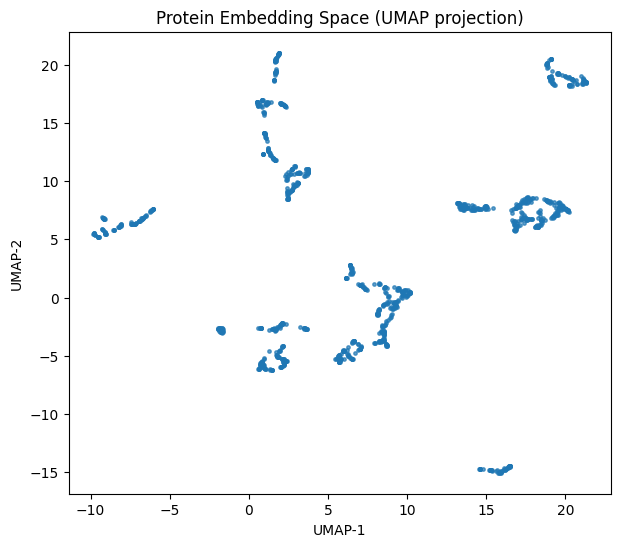

In [74]:
# reduce embeddings with UMAP
import umap, matplotlib.pyplot as plt

Z, y = [], []
for i, (fam, vecs) in enumerate(embeddings.items()):
    for v in vecs:
        Z.append(v)
        y.append(fam)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine")
U = reducer.fit_transform(Z)

plt.figure(figsize=(7,6))
plt.scatter(U[:,0], U[:,1], s=6, alpha=0.7)
plt.title("Protein Embedding Space (UMAP projection)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.show()


In [ ]:
# app.py (fixed)
# Interactive protein embedding explorer

import json, os
import pandas as pd
import plotly.express as px
import umap
import streamlit as st
from pathlib import Path
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np


# Resolve project root dynamically (one level above)
ROOT = Path(os.getcwd()).resolve().parent
RESULTS_PATH = ROOT / "results" / "embeddings.json"

st.title("Protein Embedding Explorer")

# Ensure file exists
if not RESULTS_PATH.exists():
    st.error(f"File not found: {RESULTS_PATH}")
    st.info("Run the embedding generation notebook first to create it.")
    st.stop()

# Load embeddings
with open(RESULTS_PATH, "r") as f:
    data = json.load(f)

# Flatten into a DataFrame
rows = []
for fam, vecs in data.items():
    for v in vecs:
        rows.append({"family": fam, **{f"d{i}": v[i] for i in range(len(v))}})
df = pd.DataFrame(rows)

# UMAP for 2D projection
Z = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine").fit_transform(
    df[[c for c in df.columns if c.startswith("d")]]
)
df["x"], df["y"] = Z[:, 0], Z[:, 1]


# Assign embeddings variable to loaded data
embeddings = data
all_vecs = np.array([v for fam in embeddings.values() for v in fam])
all_fams = [fam for fam, vecs in embeddings.items() for _ in vecs]

query = all_vecs[0:1] #pick one
scores = cosine_similarity(query, all_vecs)[0]
topk = np.argsort(-scores)[:10]

print("Query family:", all_fams[0])
for i in topk:
    print(f" {all_fams[i]} ({scores[i]:.3f})")

# Plot
fig = px.scatter(df, x="x", y="y", color="family", title="Protein Embeddings (UMAP)")
st.plotly_chart(fig, use_container_width=True)



2025-11-11 01:23:27.601 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 01:23:27.602 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 01:23:27.603 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 01:23:28.420 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 01:23:28.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 01:23:28.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 01:23:28.421 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-11 01:23:28.422 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Query family: Antenna
 Antenna (1.000)
 Antenna (0.998)
 Antenna (0.998)
 Antenna (0.998)
 Antenna (0.998)
 Antenna (0.997)
 Antenna (0.997)
 Antenna (0.997)
 Antenna (0.995)
 Antenna (0.994)


DeltaGenerator()